In [170]:
from keras.layers import Input, Dense, Embedding, Flatten, dot, BatchNormalization
from keras.models import Model, load_model 
from keras.utils import get_custom_objects
import keras.backend as K
from keras.callbacks import EarlyStopping,ModelCheckpoint

from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from IPython.display import display
import pandas as pd
import numpy as np
import os
from random import shuffle, randint, sample
from IPython.display import display
from sklearn.utils import shuffle
from sklearn import preprocessing
import matplotlib.pyplot as plt
from adjustText import adjust_text


In [46]:
randint(0,2)

0

# generate data

In [3]:
movies=pd.DataFrame({'movie_id':range(6)})
movies

,movie_id
0,0
1,1
2,2
3,3
4,4
5,5


In [6]:
users=pd.DataFrame({'user_id':range(40000)})
users.tail()

,user_id
39995,39995
39996,39996
39997,39997
39998,39998
39999,39999


In [11]:
pd.DataFrame([[1,2,3],[4,5,6]],columns=['a','b','c'])

,a,b,c
0,1,2,3
1,4,5,6


In [201]:
# 0~10000, 0/1 4~5, 2/3 1~2, 4/5 1~2
# 10000~20000, 2/3 4~5, 0/1 1~2, 4/5 1~2
# 20000~30000, 4/5 4~5, 2/3 1~2, 0/1 1~2
# 30000~40000, 0/5 4~5, 1/2 1~2, 3/4 1~2

dummy=[]

for user in range(40000):
    for movie in range(6):
        if user in range(10000):
            if movie in [0,1]:
                dummy.append([user,movie,randint(2,3)])
            elif movie in [2,3]:
                dummy.append([user,movie,randint(-3,-2)])
            elif movie in [4,5]:
                dummy.append([user,movie,randint(-3,-2)])
       
        elif user in range(10000,20000):
            if movie in [2,3]:
                dummy.append([user,movie,randint(2,3)])
            elif movie in [0,1]:
                dummy.append([user,movie,randint(-3,-2)])
            elif movie in [4,5]:
                dummy.append([user,movie,randint(-3,-2)])
        
        elif user in range(20000,30000):
            if movie in [4,5]:
                dummy.append([user,movie,randint(2,3)])
            elif movie in [2,3]:
                dummy.append([user,movie,randint(-3,-2)])
            elif movie in [0,1]:
                dummy.append([user,movie,randint(-3,-2)])
        
        elif user in range(30000,40000):
            if movie in [0,5]:
                dummy.append([user,movie,randint(2,3)])
            elif movie in [2,3]:
                dummy.append([user,movie,randint(-3,-2)])
            elif movie in [4,1]:
                dummy.append([user,movie,randint(-3,-2)])

data=pd.DataFrame(dummy,columns=['user_id','movie_id','rating'])
data.tail(10)

,user_id,movie_id,rating
239990,39998,2,-3
239991,39998,3,-3
239992,39998,4,-3
239993,39998,5,3
239994,39999,0,3
239995,39999,1,-2
239996,39999,2,-3
239997,39999,3,-3
239998,39999,4,-3
239999,39999,5,2


In [205]:
data[data.user_id==11112]

,user_id,movie_id,rating
66672,11112,0,-3
66673,11112,1,-2
66674,11112,2,2
66675,11112,3,3
66676,11112,4,-3
66677,11112,5,-3


In [206]:
data_train, data_test, _, _ = train_test_split(data, data, test_size=0.1, random_state=42)

In [207]:
x_train=[data_train.user_id.values,
         data_train.movie_id.values]
y_train=[data_train.rating.values]

x_valid=[data_test.user_id.values,
         data_test.movie_id.values]
y_valid=[data_test.rating.values]



# model

In [208]:
def rmse(y_true, y_pred, bound=2):
    max_rating=bound*2
    y_pred = K.clip(y_pred, 0.0, max_rating)
    return K.sqrt(K.mean(K.pow(y_true - y_pred, 2)))

get_custom_objects().update({"rmse": rmse})


In [209]:
input_length=1
n_movies=6
n_users=40000
latent_dim=30

user_input = Input(shape=(input_length,))
movie_input = Input(shape=(input_length,))

user_vecter = Embedding(input_dim=n_users, output_dim=latent_dim, input_length=input_length, embeddings_initializer="random_normal")(user_input)
user_vecter = Flatten()(user_vecter)

movie_vecter = Embedding(n_movies, latent_dim, embeddings_initializer="random_normal")(movie_input)
movie_vecter = Flatten()(movie_vecter)


rating_predict = dot([user_vecter,movie_vecter],axes=1)

model = Model([user_input,movie_input],rating_predict)

model.compile(loss="mse", optimizer="adam", metrics=[rmse])

model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 30)        1200000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 30)        180         input_6[0][0]                    
__________________________________________________________________________________________________
flatten_5 

In [210]:
# https://www.youtube.com/watch?v=BZh1ltr5Rkg
# https://stackoverflow.com/questions/47312219/what-does-non-trainable-params-mean
early_stopping = EarlyStopping(monitor='val_rmse', mode='min', verbose=1, patience=10, min_delta=0.001)
    
file_name = 'recommender'
file_name += '-'+"epoch_{epoch:02d}-val_rmse_{val_rmse:.3f}.hdf5"
path=os.path.join('.','dataset','weights',file_name)
checkpointer = ModelCheckpoint(filepath=path, verbose=1, monitor='val_rmse', save_best_only=True, mode='min', period=1)

epochs=100
batch_size=1000
history = model.fit(x_train,y_train,
                    validation_data=(x_valid,y_valid),
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=1, 
                    shuffle=True,
                    callbacks=[early_stopping,checkpointer]
                    )

Train on 216000 samples, validate on 24000 samples
Epoch 1/100
216000/216000 [==============================] - 1s 6us/step - loss: 6.4708 - rmse: 2.5492 - val_loss: 6.3479 - val_rmse: 2.5368

Epoch 00001: val_rmse improved from inf to 2.53675, saving model to ./dataset/weights/recommender-epoch_01-val_rmse_2.537.hdf5
Epoch 2/100
216000/216000 [==============================] - 1s 3us/step - loss: 5.7915 - rmse: 2.4919 - val_loss: 5.4097 - val_rmse: 2.4596

Epoch 00002: val_rmse improved from 2.53675 to 2.45956, saving model to ./dataset/weights/recommender-epoch_02-val_rmse_2.460.hdf5
Epoch 3/100
216000/216000 [==============================] - 1s 4us/step - loss: 3.9323 - rmse: 2.3226 - val_loss: 4.1346 - val_rmse: 2.3550

Epoch 00003: val_rmse improved from 2.45956 to 2.35496, saving model to ./dataset/weights/recommender-epoch_03-val_rmse_2.355.hdf5
Epoch 4/100
216000/216000 [==============================] - 1s 4us/step - loss: 2.3363 - rmse: 2.1799 - val_loss: 3.3915 - val_rmse: 

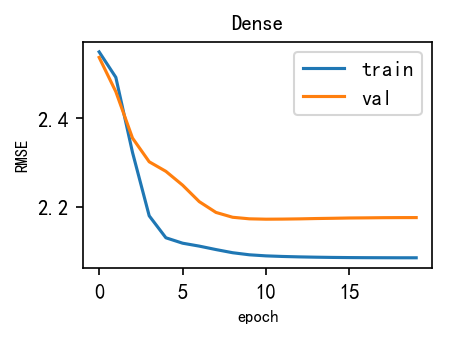

In [211]:
def plot_history(history):
    plt.figure(figsize=(3,2), dpi=150)
    plt.plot(history.history['rmse'])
    plt.plot(history.history['val_rmse'])
    plt.title('Dense', fontsize=10)
    plt.ylabel('RMSE', fontsize=8)
    plt.xlabel('epoch', fontsize=8)
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history)

# load best model

In [222]:
path=os.path.join('.','dataset','weights','recommender-epoch_11-val_rmse_2.172.hdf5')
best_nn=load_model(path)
best_nn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 30)        1200000     input_5[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 1, 30)        180         input_6[0][0]                    
__________________________________________________________________________________________________
flatten_5 

In [223]:
best_nn.layers

In [224]:
input_ = best_nn.layers[0].input
x = best_nn.layers[2](input_)
output_ = best_nn.layers[4](x)
model_user_embedding = Model(input_, output_)
model_user_embedding.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 1, 30)             1200000   
_________________________________________________________________
flatten_5 (Flatten)          (None, 30)                0         
Total params: 1,200,000
Trainable params: 1,200,000
Non-trainable params: 0
_________________________________________________________________


In [225]:
user_vectors=model_user_embedding.predict([40000-1,40000-0])
print(user_vectors.shape)
user_vectors

(2, 30)


array([[-0.10365929, -0.11228621,  0.20402902,  0.28201097, -0.35630617,
        -0.02781797, -0.26417738,  0.0494066 , -0.01915489, -0.08769593,
         0.04389039,  0.08652047, -0.06342518, -0.14308892,  0.10689261,
         0.02507435, -0.04540818,  0.06569954, -0.03742193,  0.10352001,
         0.09331168,  0.00453348, -0.20464954,  0.21947613,  0.00363352,
         0.01927173,  0.02818288, -0.14583892, -0.0670023 ,  0.13546875],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]],
      dtype=float32)

In [226]:
user_vectors=model_user_embedding.predict(list(range(40000)))
print(user_vectors.shape)

(40000, 30)


# tsne

In [227]:
select_index=(sample(range(0, 10000), 20)+
              sample(range(10000, 20000), 20)+
              sample(range(20000, 30000), 20)+
              sample(range(30000, 40000), 20))

select_user_vectors=user_vectors[select_index,...]
select_user_vectors.shape

(80, 30)

In [228]:
model_tsne = TSNE(n_components=2, random_state=0, perplexity=40)
select_user_vectors_tsne = model_tsne.fit_transform(select_user_vectors)
select_user_vectors_tsne.shape

(80, 2)

# visualize

In [229]:
data_vis = pd.DataFrame({'user_id':select_index,
                         'embedding_vec':list(select_user_vectors),
                         'tsne_vec':list(select_user_vectors_tsne),})
data_vis.tail()

,user_id,embedding_vec,tsne_vec
75,33850,"[-0.09184663, -0.07213589, 0.14808263, 0.14397...","[2.1465945, 1.49499]"
76,32269,"[-0.10751598, -0.16467974, 0.18002242, 0.25622...","[2.176352, 1.9091196]"
77,35296,"[-0.066164985, -0.18389481, 0.06360926, 0.1422...","[1.8612885, 1.718255]"
78,35539,"[-0.039381664, -0.05634538, 0.16411668, 0.1683...","[1.9604392, 2.1700249]"
79,38432,"[-0.05896752, -0.1035334, 0.123132035, 0.25508...","[1.7556013, 2.2407458]"


In [230]:
word = select_index
x = select_user_vectors_tsne[:,0]
y = select_user_vectors_tsne[:,1]


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79


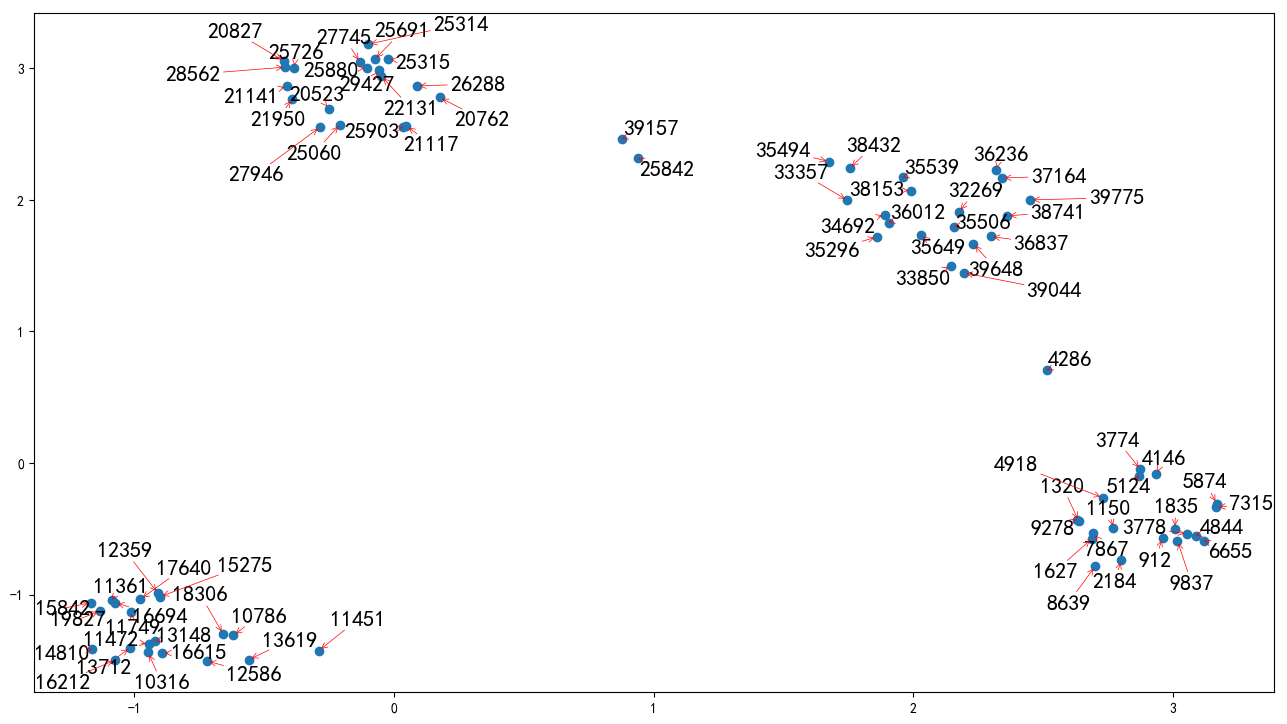

In [231]:
x_y_word = []
plt.figure(figsize=(16,9),dpi=100)
plt.rcParams['axes.unicode_minus'] = False 

plt.scatter(x,y)

i=0
for a, b, s in zip(x, y, word):
    print(i)
    i+=1
    x_y_word.append(plt.text(a, b, s, fontsize=16))
    
adjust_text(x_y_word, arrowprops=dict(arrowstyle="->", color='r', lw=0.5))

plt.show()